In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
%matplotlib inline

import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# データのインポート

In [3]:
folder_path = './ieee-fraud-detection'
train_identity = pd.read_csv(f'{folder_path}/train_identity.csv')
train_transaction = pd.read_csv(f'{folder_path}/train_transaction.csv')
test_identity = pd.read_csv(f'{folder_path}/test_identity.csv')
test_transaction = pd.read_csv(f'{folder_path}/test_transaction.csv')
sample_sub = pd.read_csv(f'{folder_path}/sample_submission.csv')

train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# 欠損

In [13]:
def missing_table(df):
    null_val = df.isnull().sum()
    percent = 100 * null_val / len(df)
    missing = pd.concat([null_val, percent], axis=1)
    missing_columns = missing.rename(columns={0:"missing", 1:"%"})
    return missing_columns

missing_table(train).to_csv('./EDA_item/missing_table.csv')

In [14]:
missing_table(test).to_csv('./EDA_item/missing_table_test.csv')

# データを眺める

## ランダムサンプリング

In [9]:
train_random = train.sample(frac=0.02, random_state=0).sort_values('TransactionID')
train_random.to_csv('./EDA_item/train_random.csv')

## 時間の分布

Text(0.5,1,'Distribution of transaction date')

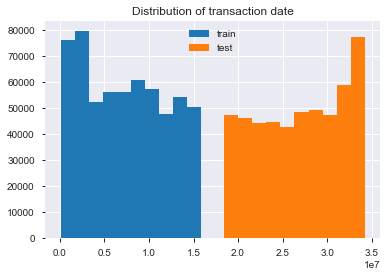

In [11]:
plt.hist(train['TransactionDT'], label='train')
plt.hist(test['TransactionDT'], label='test')
plt.legend()
plt.title('Distribution of transaction date')

## Distribution of Fraud in train data

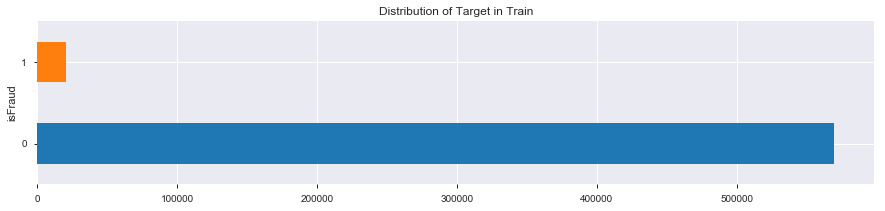

In [14]:
train.groupby('isFraud').count()['TransactionID'].plot(kind='barh', title='Distribution of Target in Train', figsize=(15, 3))
plt.show()

## Distribution of log TransactionAmt

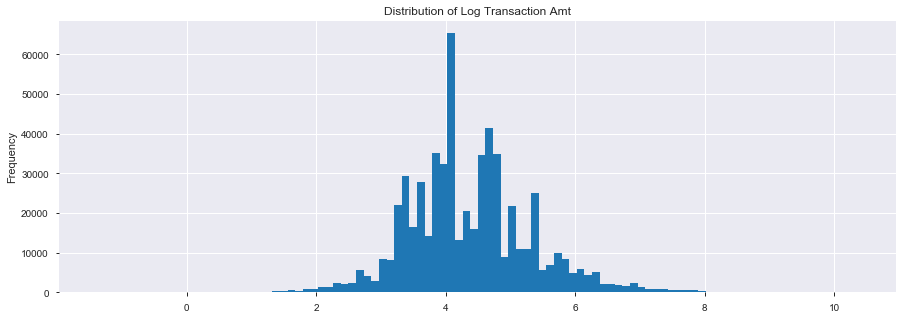

In [15]:
train['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

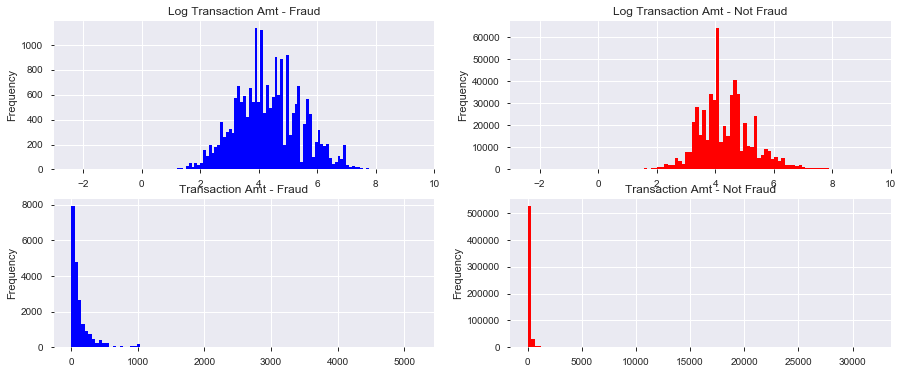

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color='b',
          xlim=(-3, 10),
         ax= ax1)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color='r',
          xlim=(-3, 10),
         ax=ax2)
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color='b',
         ax= ax3)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color='r',
         ax=ax4)
plt.show()

In [19]:
print('Mean transaction amt for fraud is {:.4f}'.format(train.loc[train['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(train.loc[train['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non-fraud is 134.5117


## Distribution of card6 of fraud or non-fraud data

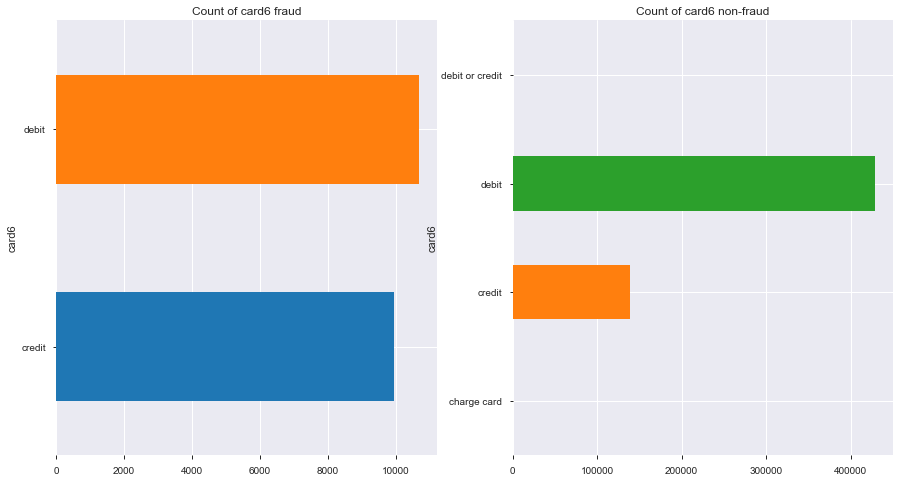

In [21]:
train_fraud = train.loc[train['isFraud'] == 1]
train_notfraud = train.loc[train['isFraud'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
train_fraud.groupby('card6')['card6'].count().plot(kind='barh', ax=ax1, title='Count of card6 fraud')
train_notfraud.groupby('card6')['card6'].count().plot(kind='barh', ax=ax2, title='Count of card6 non-fraud')
plt.show()

## C1 - C14

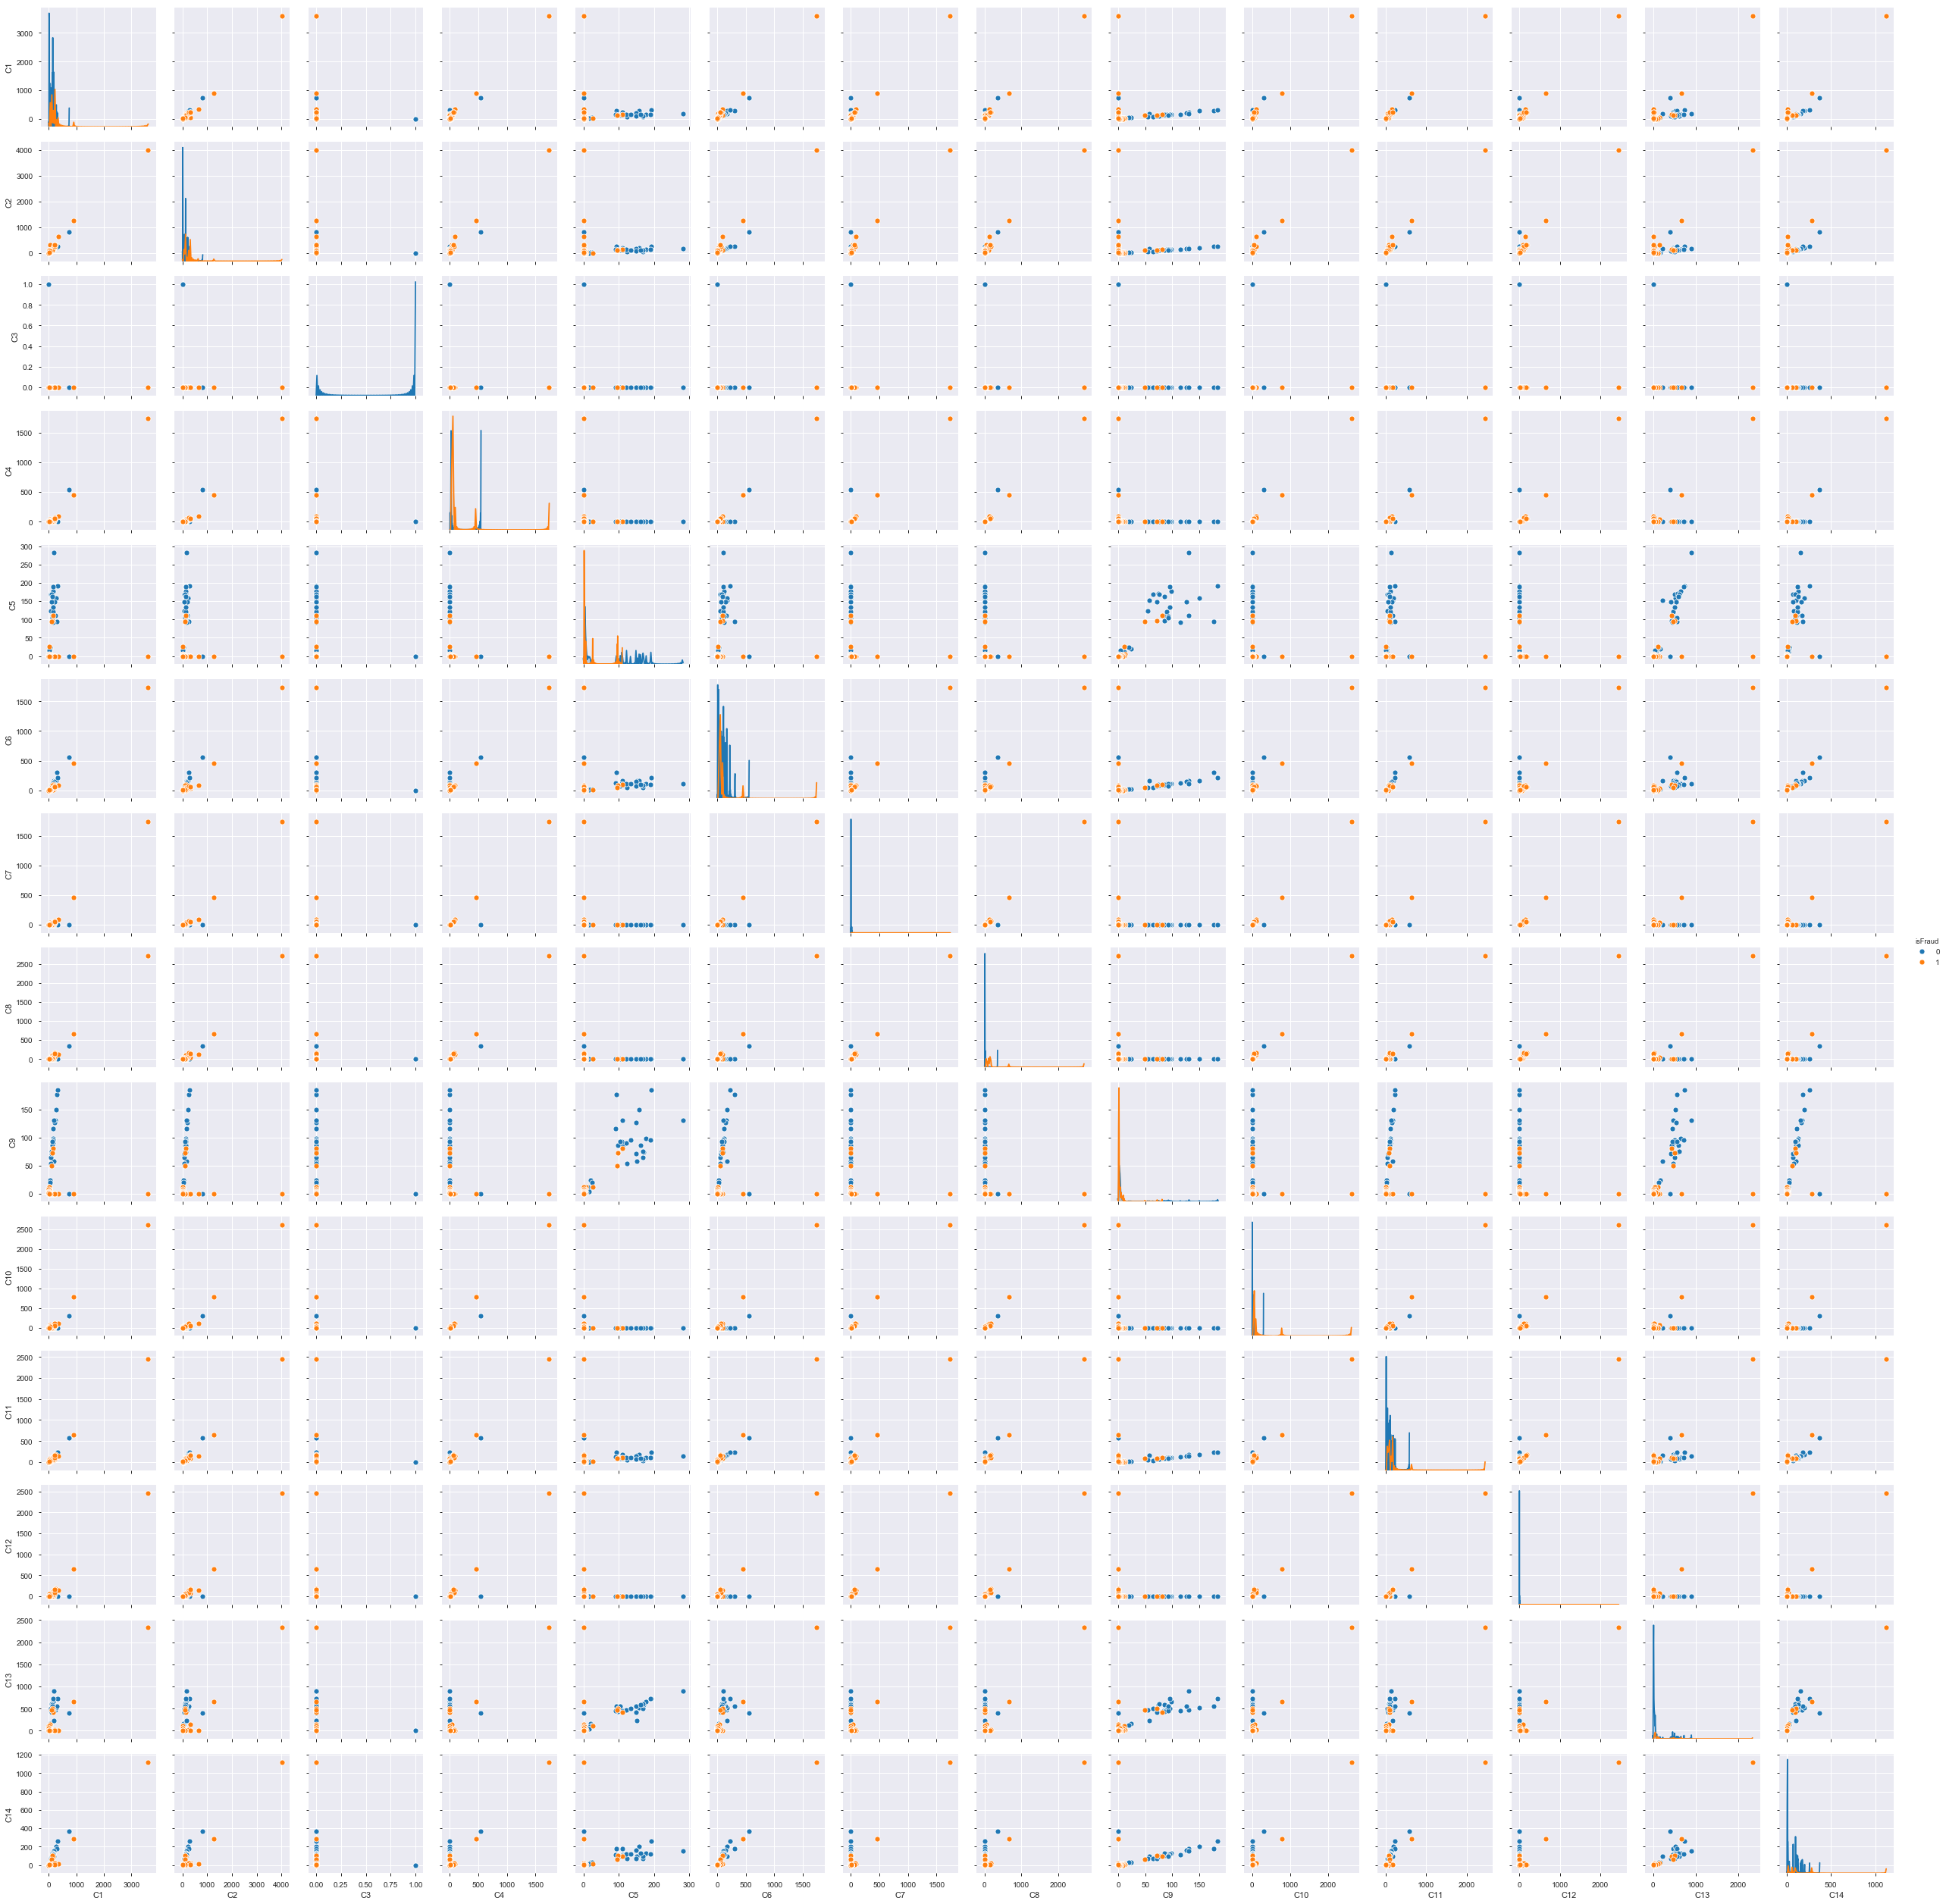

In [22]:
c_cols = [c for c in train if c[0] == 'C']
sampled_train = pd.concat([train.loc[train['isFraud'] == 0].sample(500), 
                          train.loc[train['isFraud'] == 1].sample(500)])

sns.pairplot(sampled_train, hue='isFraud', vars=c_cols)
plt.show()

## D1 - D15

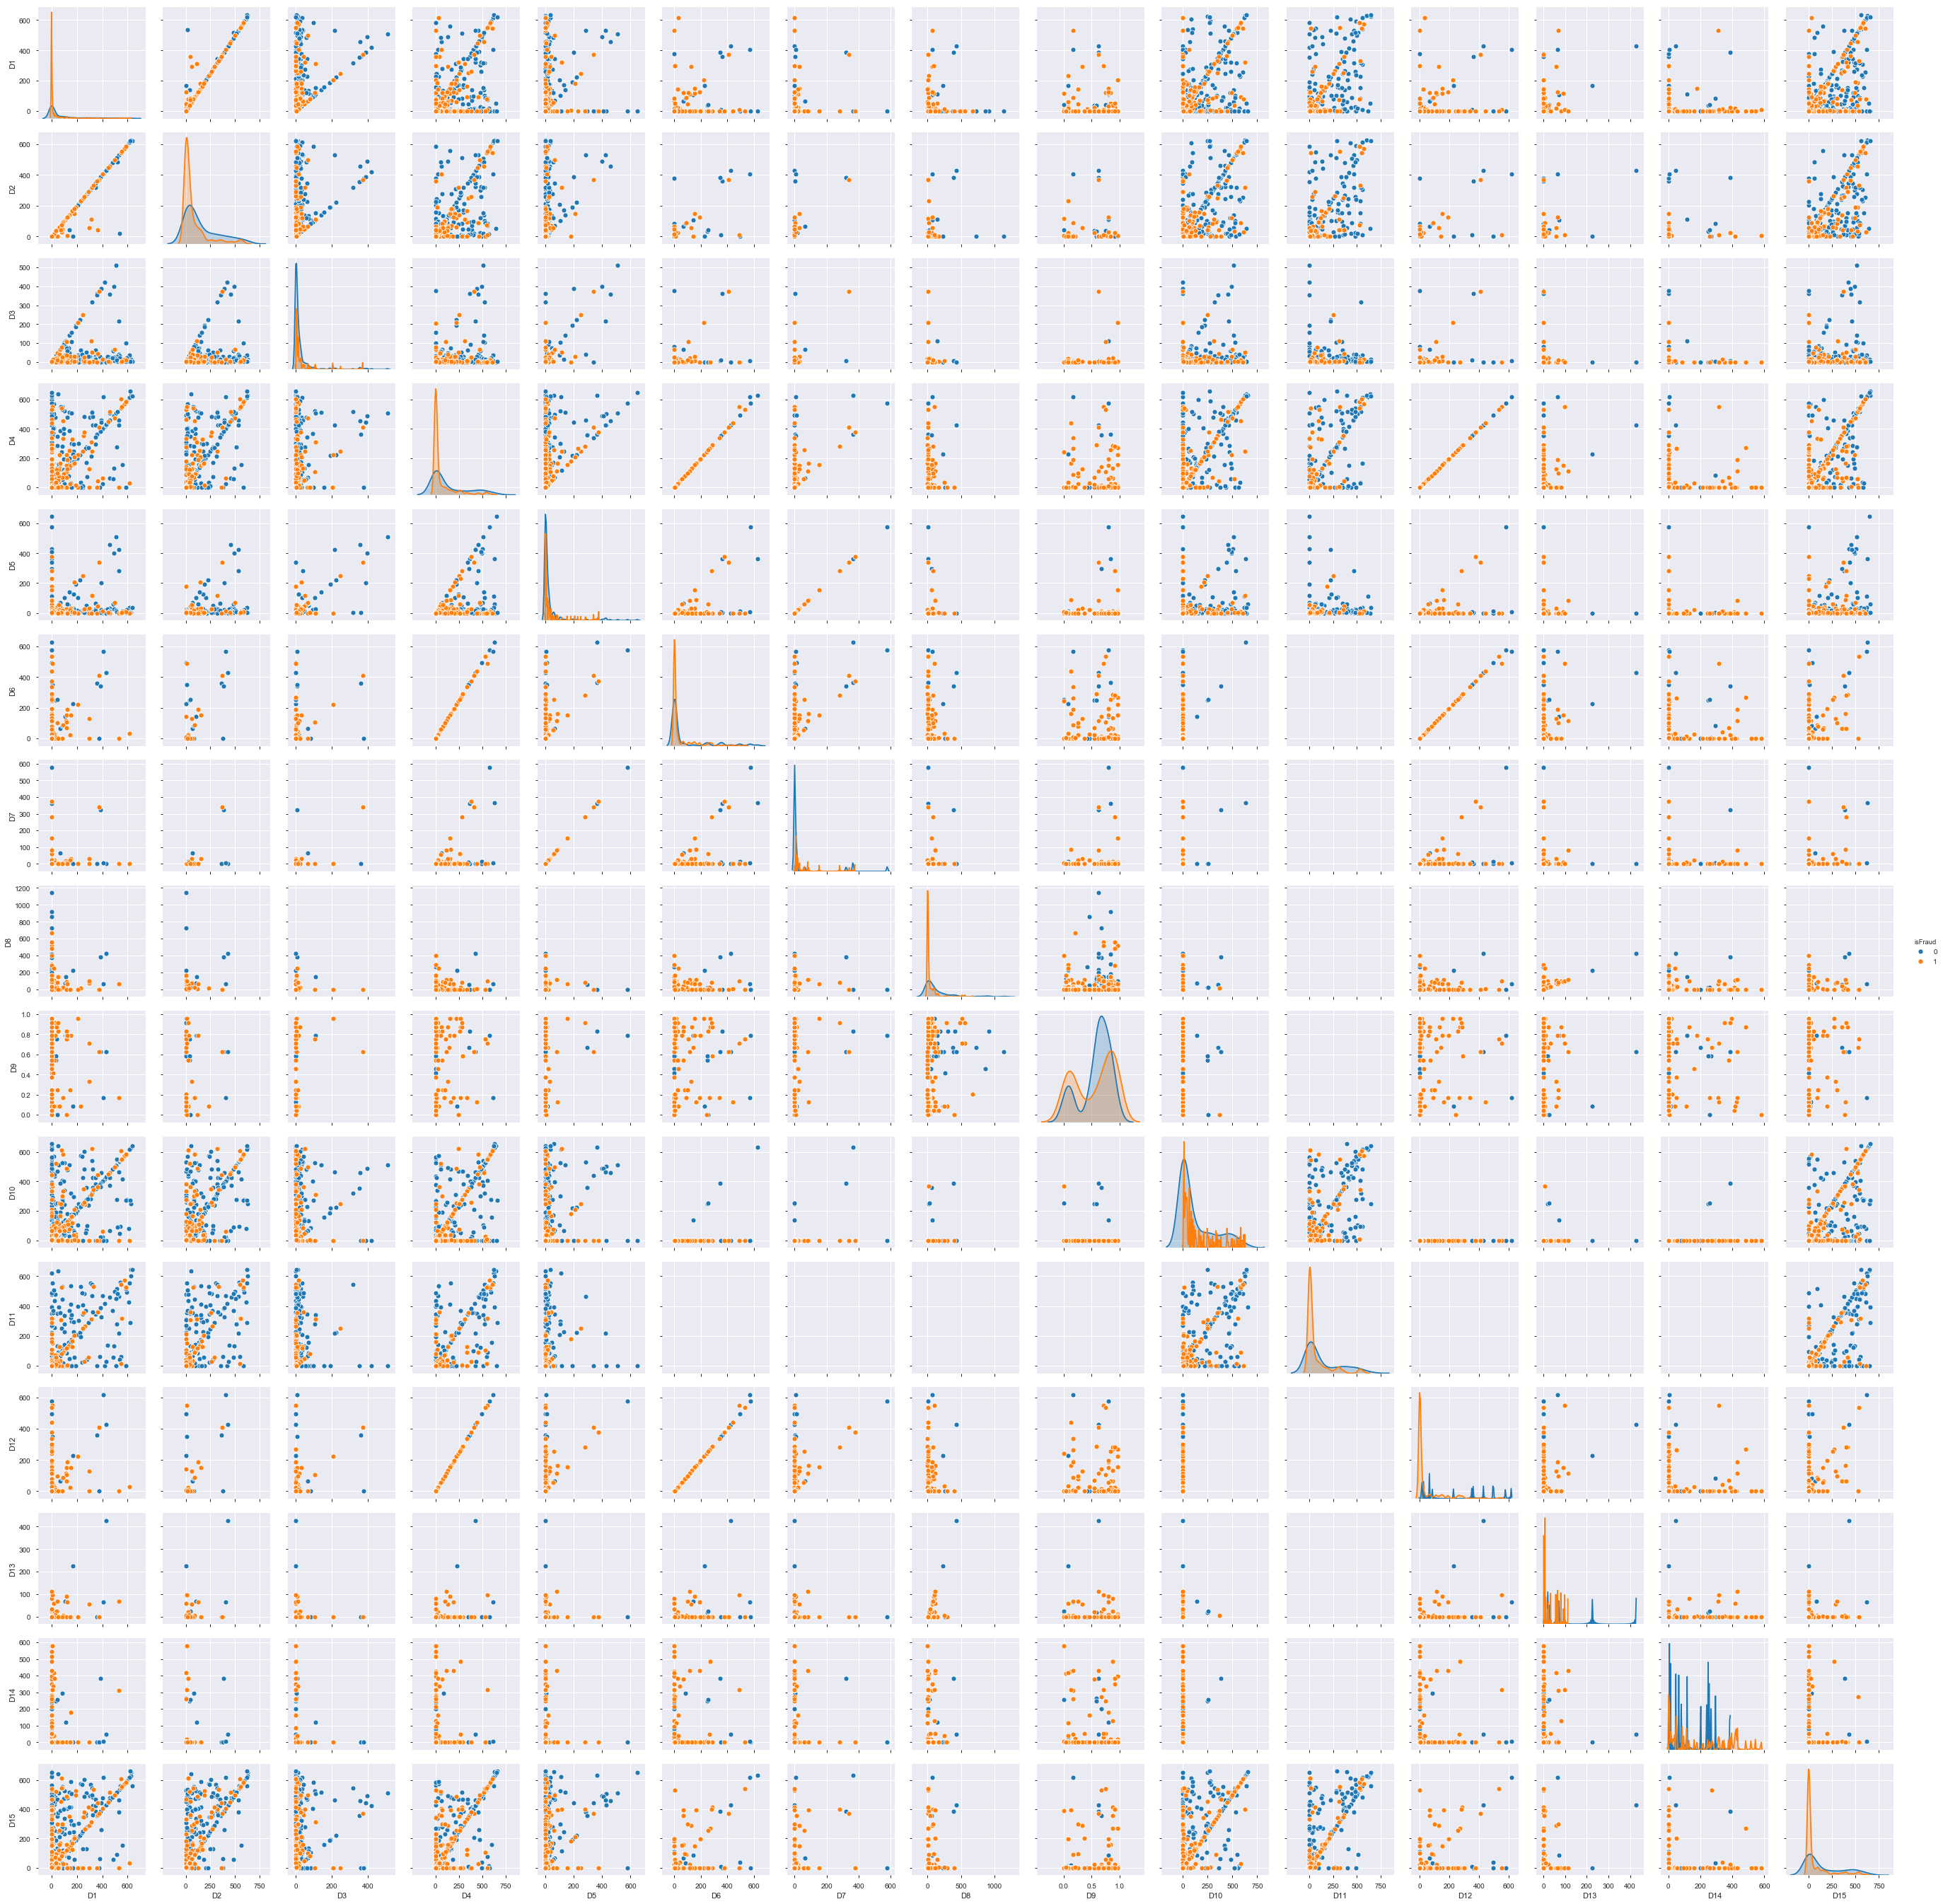

In [23]:
d_cols = [c for c in train_transaction if c[0] == 'D']
sns.pairplot(sampled_train, hue='isFraud', vars=d_cols)
plt.show()

In [4]:
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
start_date = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
dates_range = pd.date_range(start='2017-10-01', end='2019-01-01')
us_holidays = calendar().holidays(start=dates_range.min(), end=dates_range.max())

In [5]:
for df in [train, test]:
    df['uid'] = df['card1'].astype(str) + '_' + df['card2'].astype(str)
    df['uid2'] = df['uid'].astype(str) + '_' + df['card3'].astype(str) + '_' + df['card5'].astype(str)
    df['uid3'] = df['uid2'].astype(str) + '_' + df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
    df['uid4'] = df['uid3'].astype(str) + '_' + df['P_emaildomain'].astype(str)
    df['uid5'] = df['uid3'].astype(str) + '_' + df['R_emaildomain'].astype(str)
    
    df['DT'] = df['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))
    df['DT_M'] = (df['DT'].dt.year - 2017) * 12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year - 2017) * 52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year - 2017) * 365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    df['is_december'] = df['DT'].dt.month
    df['is_december'] = df['is_december']==12
    df['is_holiday'] = df['DT'].dt.date.astype('datetime64').isin(us_holidays)

In [6]:
def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        temp_df = pd.concat([train[[col]], test[[col]]])
        fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col] = test[col].map(fq_encode)
        else:
            train[col + '_fq_enc'] = train[col].map(fq_encode)
            test[col + '_fq_enc'] = test[col].map(fq_encode)
        
    return train, test

In [7]:
def timeblock_frequency_encoding(train, test, periods, columns, with_proportions=True, only_proportions=False):
    for period in periods:
        for col in columns:
            new_col = col + '_' + period
            train[new_col] = train[col].astype(str) + '_' + train[period].astype(str)
            test[new_col] = test[col].astype(str) + '_' + test[period].astype(str)
            
            temp_df = pd.concat([train[[new_col]], test[[new_col]]])
            fq_encode = temp_df[new_col].value_counts().to_dict()
            
            train[new_col] = train[new_col].map(fq_encode)
            test[new_col] = test[new_col].map(fq_encode)
            
            if only_proportions:
                train[new_col] = train[new_col] / train[period + '_total']
                test[new_col] = test[new_col] / test[period + '_total']
                
            if with_proportions:
                train[new_col + '_proportions'] = train[new_col] / train[period + '_total']
                test[new_col + '_proportions'] = test[new_col] / test[period + '_total']
                
    return train, test

In [8]:
for col in ['DT_M', 'DT_W', 'DT_D']:
    temp_df = pd.concat([train[[col]], test[col]])
    fq_encode = temp_df[col].value_counts().to_dict()
    train[col + '_total'] = train[col].map(fq_encode)
    test[col + '_total'] = test[col].map(fq_encode)

In [9]:
i_cols = ['uid']
periods = ['DT_D', 'DT_W', 'DT_M']
train, test = timeblock_frequency_encoding(train, test, periods, i_cols, with_proportions=False, only_proportions=True)

In [10]:
i_cols = ['card1', 'uid', 'uid2', 'uid3', 'uid4', 'uid5']
train, test = frequency_encoding(train, test, i_cols)

In [11]:
n_fold = 5
kf = TimeSeriesSplit(n_splits=n_fold)

In [12]:
target_mean = train['isFraud'].mean()
#下の特徴量を再考
i_cols = ['ProductCD', 'card1_fq_enc', 'card2', 'card3', 'card5',
          'uid_fq_enc', 'uid2_fq_enc', 'uid3_fq_enc', 'uid4_fq_enc', 'uid5_fq_enc',
          'addr1', 'addr2', 'P_emaildomain']
for col in i_cols:
    train[col + '_target_enc'] = target_mean
    
    for i, (previous_index, current_index) in enumerate(kf.split(train)):
        
        if i == 0:
            continue
            
        else:
            train_previous = train.iloc[previous_index]
            col_num = train.columns.get_loc(col + '_target_enc')
            
            temp_dict = train_previous.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_enc'})
            temp_dict.index = temp_dict[col].values
            temp_dict = temp_dict[col + '_target_enc'].to_dict()
            
            train.iloc[current_index, col_num] = train.iloc[current_index][col].map(temp_dict)
    
    temp_dict = train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_enc'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_enc'].to_dict()
    test[col + '_target_enc'] = test[col].map(temp_dict)

In [40]:
i_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
col = 'card1'
temp_df = pd.concat([train[i_cols], test[i_cols]])
unique_encode = temp_df.groupby([col])['card2'].nunique().to_dict()
#unique_encode = temp_df['card1'].value_counts(dropna=False).to_dict()
train['card1_by_card2_countuniq'] = train['card1'].map(unique_encode)

In [42]:
i_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
temp_df = pd.concat([train[i_cols], test[i_cols]])
for i, col in enumerate(i_cols):
    for j in range(i + 1, len(i_cols)):
        to_unique = i_cols[j]
        unique_encode = temp_df.groupby([col])[to_unique].nunique().to_dict()
        train[col + '_by_' + to_unique + '_countuniq'] = train[col].map(unique_encode)
        test[col + '_by_' + to_unique + '_countuniq'] = test[col].map(unique_encode)

In [45]:
periods = [5, 10, 30, 50]
i_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
for col in i_cols:
    for period in periods:
        for df in [train, test]:
            df[col + '_previous_' + str(period) + '_days_count'] = df.groupby([col])['TransactionID'].rolling(center=False, window=period).count().reset_index(drop=True)
            df[col + '_previous_' + str(period) + '_days_count'] = df.groupby([col])[col + '_previous_' + str(period) + '_days_count'].shift(periods=1)

TypeError: must be str, not int

In [49]:
from sklearn.neighbors import NearestNeighbors
knn_feature = [ 'TransactionAmt',
                'uid4_D5_std',
                'uid4_TransactionAmt_std',
                'uid4_D2_std',
                'uid4_D4_std',
                'uid4_D5_mean',
                'uid4_D3_std',
                'uid5_TransactionAmt_std',
                'TransactionAmt_to_std_card1',
                'uid4_D2_mean',
                'TransactionAmt_DT_D_std_score',
                'uid5_D3_mean',
                'uid4_TransactionAmt_mean',
                'uid4_D3_mean',
                'uid3_D9_mean']

In [51]:
target_mean = train['isFraud'].mean()

for col in i_cols:
    train[col + '_knn'] = target_mean
    
    for i, (previous_index, current_index) in enumerate(kf.split(train)):
        
        if i == 0:
            continue
            
        else:
            train_previous = train.iloc[previous_index]
            train_current = train.iloc[current_index]
            col_num = train.columns.get_loc(col + '_knn')
            
            knn = NearestNeighbors(n_neighbors=500)
            knn.fit(train_previous[knn_feature])
            neighbors = knn.kneighbors(train_current[knn_feature], return_distance=False)

"""
            temp_dict = train_previous.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_enc'})
            temp_dict.index = temp_dict[col].values
            temp_dict = temp_dict[col + '_target_enc'].to_dict()
            
            train_.iloc[current_index, col_num] = train_.iloc[current_index][col].map(temp_dict)
    
    temp_dict = train_.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_enc'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_enc'].to_dict()
    test_[col + '_target_enc'] = test_[col].map(temp_dict)
"""

KeyError: "[('TransactionAmt', 'uid4_D5_std', 'uid4_TransactionAmt_std', 'uid4_D2_std', 'uid4_D4_std', 'uid4_D5_mean', 'uid4_D3_std', 'uid5_TransactionAmt_std', 'TransactionAmt_to_std_card1', 'uid4_D2_mean', 'TransactionAmt_DT_D_std_score', 'uid5_D3_mean', 'uid4_TransactionAmt_mean', 'uid4_D3_mean', 'uid3_D9_mean')] not in index"

In [105]:
len(train['addr2'].unique())

75

In [7]:
pd_addr = pd.DataFrame()
pd_addr['count'] = train.groupby(['addr1', 'addr2'])['isFraud'].count()
pd_addr['sum'] = train.groupby(['addr1', 'addr2'])['isFraud'].sum()
pd_addr

count  sum
addr1 addr2            
100.0 31.0      26    0
101.0 14.0       1    0
102.0 96.0      13    0
104.0 87.0       8    0
105.0 87.0       3    0
106.0 87.0      20    0
110.0 87.0    3220   64
111.0 16.0       1    0
      22.0       1    0
112.0 29.0       2    0
113.0 87.0       1    0
117.0 101.0      1    0
119.0 32.0       3    0
120.0 96.0       1    0
122.0 27.0       5    0
      87.0    1612  117
123.0 32.0       2    0
      34.0       1    0
      87.0   16102  398
124.0 60.0       1    0
125.0 87.0       4    0
126.0 60.0       1    0
      61.0       3    0
      87.0   15236  386
      96.0       3    0
127.0 87.0       1    0
128.0 87.0       1    0
129.0 32.0       1    0
130.0 60.0     342   29
131.0 101.0      1    0
...            ...  ...
505.0 16.0       1    0
506.0 66.0       1    0
507.0 60.0       4    0
508.0 60.0      70    3
509.0 87.0       3    0
511.0 60.0     157   10
512.0 19.0       1    0
      27.0       4    0
      87.0    8263  284
513.0 26.0       2    0
514.0 87.0       3    0
515.0 96.0       2    0
516.0 19.0       1    0
517.0 87.0       2    0
518.0 72.0       2    0
519.0 87.0       1    0
520.0 60.0      26    0
521.0 96.0       6    0
522.0 87.0       1    0
523.0 32.0       1    0
      60.0       2    0
526.0 65.0       1    0
527.0 71.0       4    0
528.0 88.0       2    0
529.0 60.0       7    0
530.0 60.0       1    0
531.0 102.0      1    0
535.0 87.0       2    0
536.0 96.0     309   50
540.0 60.0       6    0

[437 rows x 2 columns]

In [ ]:
dupli_id = tr.duplicated(keep=False, subset=['TransactionAmt', 'ProductCD', 'card1', 'card2'])
train_dupli = tr[dupli_id]
train_same = pd.DataFrame(tr.groupby(['TransactionAmt', 'ProductCD', 'card1', 'card2'])['isFraud'].mean())
train_same['count'] = tr.groupby(['TransactionAmt', 'ProductCD', 'card1', 'card2'])['isFraud'].count()
train_same

In [ ]:
X.fillna(-999, inplace=True)
X_test.fillna(-999, inplace=True)

In [ ]:
def ridge_feature_selection(X, y, alpha=1.0, random_state=None):
    score = 0
    for i, (train_index, valid_index) in enumerate(kf.split(X, y)):
        #print(f'Training on fold {i + 1}')
    
        X_train = X.iloc[train_index]
        y_train = y[train_index]
        X_valid = X.iloc[valid_index]
        y_valid = y[valid_index]
    
        clf_ridge = RidgeClassifier()
        clf_ridge.fit(X, y)
        y_pred = clf_ridge.predict(X_valid)
    
        #print(f'FOLD_{i + 1}: AUC {roc_auc_score(y_valid, y_pred)}')
        score += roc_auc_score(y_valid, y_pred) / n_fold
    
        del X_train, X_valid, y_train, y_valid
        gc.collect()
    
    #print(f'\nMEAN AUC = {score}')
    return score

In [ ]:
feature_col = ['TransactionAmt']
score = ridge_feature_selection(X[feature_col], y)
for col in tqdm_notebook(X.columns[1:]):
    feature_col.append(col)
    score_i = ridge_feature_selection(X[feature_col], y)
    
    if score_i >= score:
        score = score_i
        continue
    else:
        feature_col = feature_col[:-1]
        continue
len(feature_col)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler, InstanceHardnessThreshold, NearMiss
from imblearn.over_sampling import SMOTE
#from imblearn.combine import SMOTEENN, SMOTETomek
positive_count = y.sum()

def resampling(x, y, method='random', ratio=.20, random_state=None):
    # random
    if method == 'random_down':
        rus = RandomUnderSampler(sampling_strategy=ratio, random_state=random_state)
        x_resampled, y_resampled = rus.fit_sample(x, y)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)
    
    elif method == 'random':
        rus = RandomUnderSampler(sampling_strategy=ratio / 2., random_state=random_state)
        # rus = RandomUnderSampler(ratio={0:positive_count * ratio * 2., 1:positive_count}, random_state=random_state)
        x_under, y_under = rus.fit_sample(x, y)
        smote = SMOTE(sampling_strategy=ratio, random_state=random_state)
        # smote = SMOTE(ratio={0:x_under.shape[0], 1:x_under.shape[0] // ratio}, random_state=random_state)
        x_resampled, y_resampled = smote.fit_sample(x_under, y_under)
        return pd.DataFrame(x_resampled), pd.Series(y_resampled)

In [ ]:
i = 1

for method in ['random_down']:
    for random_state in [seed * i for i in range(10)]:
        exec('train_%d, y_train_%d = resampling(train_, train_["isFraud"], method=method, random_state=random_state)' % (i, i))
        exec('train_%d = np.where(train_%d == -999, np.nan, train_%d)' % (i, i, i))
        exec('train_%d = pd.DataFrame(train_%d, columns=train_.columns)' % (i, i))
        
        exec('X%d = train_%d.sort_values("TransactionDT").drop(["isFraud", "TransactionDT", "TransactionID"], axis=1)' % (i, i))
        exec('y%d = train_%d.sort_values("TransactionDT")["isFraud"].astype(bool)' % (i, i))
        
        i += 1
        
X_test = test_.drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = clean_inf_nan(X_test)
del train_1, train_2, train_3, train_
num_model = i